In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
from syndic.prep.line_extractor import LineExtractor
from syndic.prep.bloc_extractor import BlocExtractor
from syndic.prep.data_extractor import DataExtractor
from syndic.prep.grand_livre import specs as gl_specs
from syndic.prep.page_area import PageArea
import re
import tabula
import pandas as pd
import csv

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [26]:
line_extractor = LineExtractor(gl_specs.path, gl_specs.get_line_specs())
pages_lines=line_extractor.compute()

In [66]:
cumuls = gl_specs.get_cumuls(pages_lines.pages_lines)

In [27]:
bloc_interval_def = gl_specs.get_bloc_interval_def()
bloc_extractor = BlocExtractor(pages_lines, bloc_interval_def)

In [28]:
first_page_area = PageArea(pages_lines.doc[0], bloc_extractor.images[0])

# check limit pos
limit_pos = bloc_interval_def.get_limit_pos(first_page_area)
limit_area = first_page_area.get_area(limit_pos)

### Finding columns positions

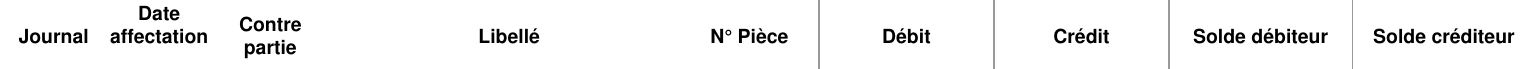

In [29]:
header_img = first_page_area.get_area((23, 75, 575, 100))
header_img

In [30]:
columns_pos=[54, 95, 130, 270, 310, 390, 445, 520]

In [31]:
blocs = bloc_extractor.read_blocs()

In [32]:
data_extractor = DataExtractor(bloc_extractor.path, gl_specs.get_data_specs())

### Test Merge rows

In [33]:
bloc_image=blocs[13].images[0]
img_area=bloc_image.area
area = [img_area[1], img_area[0], img_area[3], img_area[2]]
df=tabula.read_pdf(data_extractor.path,
                                lattice=False,
                                area=area,
                                pandas_options={'header': None},
                                columns=columns_pos,
                                pages=4)[0]
df2=df.copy()
df2

Got stderr: May 25, 2023 2:02:12 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:12 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>



0           1         2                            3         4       5
0  BQ  06/07/2022  51200002  Rgl. VIRT / PROXISERVE 2021  21026997  177,73

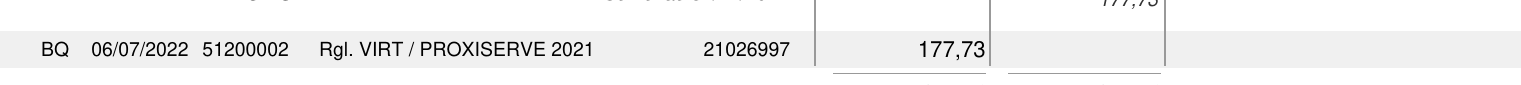

In [34]:
bloc_image.image

In [35]:
formatted_df=gl_specs.get_data_specs().data_def.format_df(df2, blocs[2])
formatted_df

journal       date  contrepartie                        label  num_piece   
0      BQ 2022-07-06      51200002  Rgl. VIRT / PROXISERVE 2021   21026997  \

    debit  credit  solde_debit  solde_credit classe classe_label    compte   
0  177.73     NaN          NaN           NaN    103      Avances  10320000  \

                     compte_label  
0  Avances dépense et travaux non

In [36]:
list((formatted_df[gl_specs.get_data_specs().row_around_merge_specs.ref_column].isnull() | formatted_df["date"].notnull()).astype(int) * formatted_df.index)

[0]

In [37]:
from syndic.prep.data_row_merge import merge_row_around
merge_row_around(formatted_df, gl_specs.get_data_specs().row_around_merge_specs)

label journal       date  contrepartie  num_piece   
id                                                                            
0   Rgl. VIRT / PROXISERVE 2021      BQ 2022-07-06      51200002   21026997  \

     debit  credit  solde_debit  solde_credit classe classe_label    compte   
id                                                                            
0   177.73     NaN          NaN           NaN    103      Avances  10320000  \

                      compte_label  
id                                  
0   Avances dépense et travaux non

In [38]:
num_page=10
pa = PageArea(pages_lines.doc[num_page], bloc_extractor.images[num_page])
pa.search_for("Total Compte")
#pa.get_area((24.360000610351562, 140.44297790527344, 572.9800415039062, 170.9299774169922))
#pa.get_area((165.17999267578125, 170.9299774169922, 209.9029541015625, 180.56898498535156))
bloc_interval_def.get_bloc_intervals(pages_lines.pages_lines[num_page].lines, pa)

[BlocInterval(start=BlocDelim(line=Line(row_num=4, content='Compte 47990000  : Compte en attente pour refacturation Cumul au 31/12/2021 11 551,44', infos={'is_compte': True, 'classe': ('479', ''), 'compte': ('47990000', 'Compte en attente pour refacturation')}), pos=Rect(39.0, 107.8249740600586, 96.58899688720703, 117.44297790527344)), end=BlocDelim(line=Line(row_num=5, content='11 551,44 0,00 Total Compte 47990000 (0 écritures) 11 551,44', infos={'classe': ('479', ''), 'compte': ('47990000', 'Compte en attente pour refacturation')}), pos=Rect(165.17999267578125, 135.9299774169922, 209.9029541015625, 145.56898498535156))),
 BlocInterval(start=BlocDelim(line=Line(row_num=7, content='Compte 48900001  : CHAPELIER Russel Cumul au 31/12/2021 202,40', infos={'is_compte': True, 'classe': ('489', 'Compte de régul'), 'compte': ('48900001', 'CHAPELIER Russel')}), pos=Rect(39.0, 200.82498168945312, 96.58899688720703, 210.44297790527344)), end=BlocDelim(line=Line(row_num=9, content='202,40 202,40 

In [39]:
# check bloc images
start_bloc_img = blocs[0].images[0].image
end_bloc_img = blocs[0].images[-1].image

In [40]:
num_page = -2
page_area = PageArea(pages_lines.doc[num_page], bloc_extractor.images[num_page])

# check first bloc interval
page_lines = pages_lines.pages_lines[num_page]
bloc_interval_def.get_bloc_intervals(page_lines.lines, page_area)

[BlocInterval(start=BlocDelim(line=Line(row_num=4, content='Compte 66200000  : Autres charges financières et agios Cumul au 31/12/2021', infos={'is_compte': True, 'classe': ('62', 'Honoraires de gestion'), 'compte': ('66200000', 'Autres charges financières et agios')}), pos=Rect(39.0, 75.8249740600586, 96.58899688720703, 85.44297790527344)), end=BlocDelim(line=Line(row_num=13, content='55,00 0,34 Total Compte 66200000 (3 écritures) 54,66', infos={'classe': ('62', 'Honoraires de gestion'), 'compte': ('66200000', 'Autres charges financières et agios')}), pos=Rect(165.17999267578125, 151.9299774169922, 209.9029541015625, 161.56898498535156))),
 BlocInterval(start=BlocDelim(line=Line(row_num=15, content='Compte 70100000  : Provisions sur opérations courantes Cumul au 31/12/2021', infos={'is_compte': True, 'classe': ('62', 'Honoraires de gestion'), 'compte': ('70100000', 'Provisions sur opérations courantes')}), pos=Rect(39.0, 216.82498168945312, 96.58899688720703, 226.44297790527344)), end

In [41]:
# check last bloc images
last_start_bloc_img = blocs[-1].images[0].image
last_end_bloc_img = blocs[-1].images[-1].image

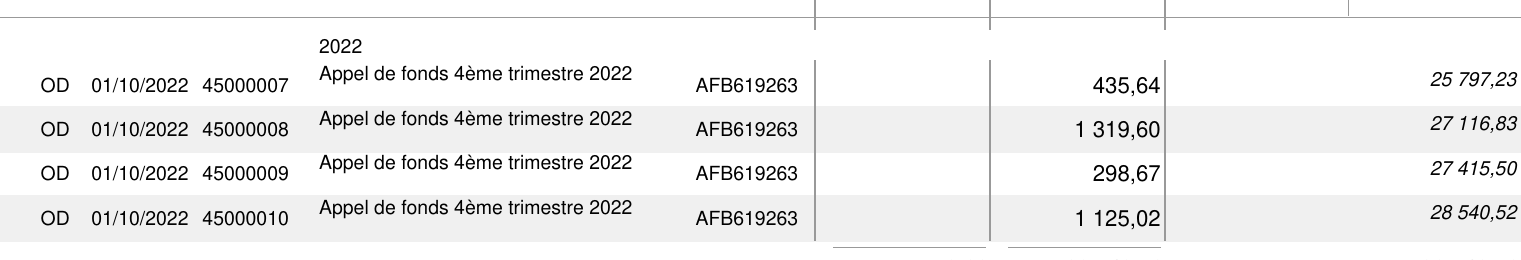

In [42]:
last_end_bloc_img # should have 4 entries 678-> 681

In [43]:
datas = data_extractor.read_datas(blocs)

Got stderr: May 25, 2023 2:02:13 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:13 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:14 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:14 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:15 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:15 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:16 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:16 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:16 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:16 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:17 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:17 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:18 P

Got stderr: May 25, 2023 2:02:36 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:36 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:37 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:37 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:38 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:38 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:39 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:39 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:40 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:40 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:41 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:02:41 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:02:42 P

Got stderr: May 25, 2023 2:03:05 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:03:05 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:03:05 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:03:05 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:03:06 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:03:06 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:03:07 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:03:07 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:03:08 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:03:08 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:03:09 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
May 25, 2023 2:03:09 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

Got stderr: May 25, 2023 2:03:10 P

KeyboardInterrupt: 

In [ ]:
datas

In [ ]:
datas.to_csv(dir_utils.get_data_dir() +"/grand-livre.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

In [68]:
cumuls.to_csv(dir_utils.get_data_dir() +"/grand-livre-cumuls.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

In [ ]:
datas.groupby("compte")[["debit", "credit"]].sum()